Epoch 1/3
13/13 [==============================] - 8s 455ms/step - loss: 32.5316 - accuracy: 0.4579 - val_loss: 0.4266 - val_accuracy: 0.7647
Epoch 2/3
13/13 [==============================] - 6s 451ms/step - loss: 0.4067 - accuracy: 0.7822 - val_loss: 0.2215 - val_accuracy: 0.8431
Epoch 3/3
4/4 [==============================] - 0s 93ms/step - loss: 0.0395 - accuracy: 0.9902
Emotion Detection - Validation Loss: 0.03952452167868614, Validation Accuracy: 0.9901960492134094


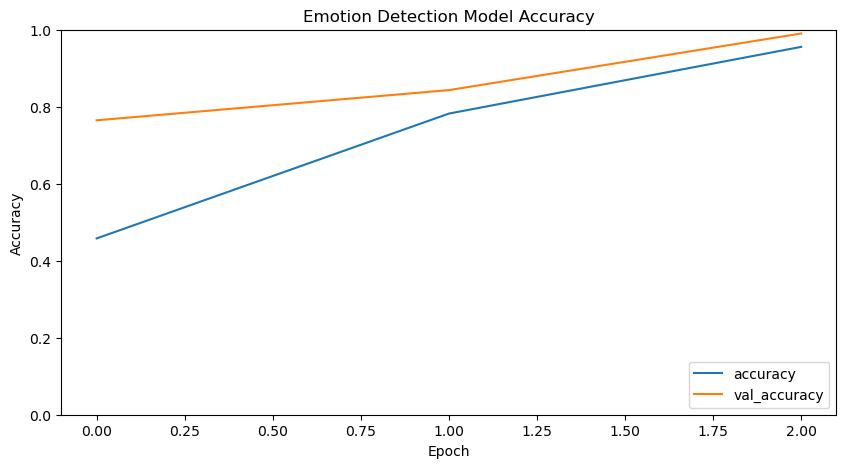

1/1 [==============================] - 0s 31ms/step


In [6]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import dlib
import pyttsx3
import matplotlib.pyplot as plt

# Defining image dimensions
img_width, img_height = 100, 100

# Loading and preprocessing images for emotion detection
X_emotion = []
y_emotion = []

emotions = ['happy', 'sad', 'neutral']

def convert_grayscale_to_rgb(image):
    """
    Convert a grayscale image to RGB.

    Args:
    image: A grayscale image.

    Returns:
    The RGB version of the input image.
    """
    return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

for emotion in emotions:
    folder = f'{emotion}'
    label = emotions.index(emotion)
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder, filename), target_size=(img_width, img_height))
        img_array = img_to_array(img)
        X_emotion.append(img_array)
        y_emotion.append(label)

X_emotion = np.array(X_emotion)
y_emotion = np.array(y_emotion)

# Splitting the data into training and validation sets for emotion detection
X_train_emotion, X_val_emotion, y_train_emotion, y_val_emotion = train_test_split(
    X_emotion, y_emotion, test_size=0.2, random_state=42
)

# Defining CNN model architecture for emotion detection
emotion_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),  # RGB images
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(emotions), activation='softmax')  # Multiclass classification for emotions
])

# Compiling the emotion detection model
emotion_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the emotion detection model
emotion_history = emotion_model.fit(
    X_train_emotion, y_train_emotion, epochs=3, batch_size=32, validation_data=(X_val_emotion, y_val_emotion)
)

# Evaluating the emotion detection model
emotion_loss, emotion_accuracy = emotion_model.evaluate(X_val_emotion, y_val_emotion)
print(f'Emotion Detection - Validation Loss: {emotion_loss}, Validation Accuracy: {emotion_accuracy}')

# Saving the emotion detection model
emotion_model.save('my_emotion_detection_model_updated.keras')

# Plotting training history
plt.figure(figsize=(10, 5))
plt.plot(emotion_history.history['accuracy'], label='accuracy')
plt.plot(emotion_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Emotion Detection Model Accuracy')
plt.show()

# Loading pre-trained face recognition model
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Loading images for Susan and Nished
nished_images_folder = "nished_images"
susan_images_folder = "susan_images"

nished_images = [os.path.join(nished_images_folder, filename) for filename in os.listdir(nished_images_folder)]
susan_images = [os.path.join(susan_images_folder, filename) for filename in os.listdir(susan_images_folder)]

engine = pyttsx3.init()

def recognize_faces_and_detect_emotions():
    """
    Recognize faces and detect emotions using the webcam.
    """
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Detecting faces
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)

        for face in faces:
            x1, y1, x2, y2 = face.left(), face.top(), face.right(), face.bottom()

            name = None  # Initializing name variable

            # Recognizing Nished and Susan's faces
            if is_nished(gray[y1:y2, x1:x2]):
                name = 'Nished'
                age = 27
                gender = 'Male'
            elif is_susan(gray[y1:y2, x1:x2]):
                name = 'Susan'
                age = 26
                gender = 'Male'

            # Checking if name is assigned a value
            if name is not None:
                # Generating the voice message
                voice_message = f"Hi {name}"

                # Speaking the voice message
                engine.say(voice_message)
                engine.runAndWait()

                # Drawing text annotations on the video frame
                cv2.putText(frame, f'Name: {name}', (x1, y1 - 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                cv2.putText(frame, f'Age: {age}', (x1, y1 - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                cv2.putText(frame, f'Gender: {gender}', (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

            # Detecting eyes (if needed) and other processing continues...

            # Extracting face ROI for emotion detection
            face_roi = gray[y1:y2, x1:x2]
            face_roi = cv2.resize(face_roi, (img_width, img_height))
            face_roi_processed = preprocess_image(face_roi)
            emotion_prediction = emotion_model.predict(face_roi_processed)
            emotion_label = emotions[np.argmax(emotion_prediction)]

            # Displaying the predicted emotion on the video frame
            cv2.putText(frame, f'Emotion: {emotion_label}', (x1, y1 - 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

            # Drawing rectangle around the face
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Detecting face landmarks
            landmarks = predictor(gray, face)
            for n in range(0, 68):
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                cv2.circle(frame, (x, y), 1, (255, 0, 0), -1)

        # Displaying the frame
        cv2.imshow('Face Recognition and Emotion Detection', frame)

        # Checking if the user pressed 'q' to quit the program
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Releasing the video capture object and closing all OpenCV windows
    cap.release()
    cv2.destroyAllWindows()

# Function to compute histogram similarity between two images
def histogram_similarity(image1, image2):
    hist1 = cv2.calcHist([image1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([image2], [0], None, [256], [0, 256])
    similarity = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    return similarity

# Function to recognize Nished's face
def is_nished(face_roi):
    nished_threshold = 0.1  # Adjust the threshold as needed
    for nished_image_path in nished_images:
        nished_image = cv2.imread(nished_image_path, cv2.IMREAD_GRAYSCALE)
        similarity = histogram_similarity(face_roi, nished_image)
        if similarity > nished_threshold:
            return True
    return False

# Function to recognize Susan's face
def is_susan(face_roi):
    susan_threshold = 0.8  # Adjust the threshold as needed
    for susan_image_path in susan_images:
        susan_image = cv2.imread(susan_image_path, cv2.IMREAD_GRAYSCALE)
        similarity = histogram_similarity(face_roi, susan_image)
        if similarity > susan_threshold:
            return True
    return False

# Function to preprocess image for emotion model prediction
def preprocess_image(img):
    if len(img.shape) == 2:  # Checking if image is grayscale
        img = convert_grayscale_to_rgb(img)
    img = cv2.resize(img, (img_width, img_height))  # Resizing to match model input size
    img = img.astype('float32') / 255.0  # Normalizing pixel values
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

# Running the face recognition and emotion detection function
recognize_faces_and_detect_emotions()
